In [1]:
import cartopy.crs as ccrs
import easygems.healpix as egh
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import intake
import colormaps as cmaps
from colormaps.utils import concat
from matplotlib.colors import ListedColormap
mpl.rcParams['figure.dpi'] = 72

In [2]:
in_dir = '/pscratch/sd/w/wcmca1/GPM/IMERG_V07B_hpss/healpix_test/'
in_file = f'{in_dir}IMERG_V07_1H_zoom9_20190101_20191231.zarr'

In [3]:
# Read data
ds = xr.open_zarr(in_file)
ds = ds.pipe(egh.attach_coords)
ds 

<xarray.Dataset> Size: 110GB
Dimensions:        (time: 8760, cell: 3145728)
Coordinates:
  * time           (time) datetime64[ns] 70kB 2019-01-01 ... 2019-12-31T23:00:00
    crs            int64 8B 0
  * cell           (cell) int32 13MB 0 1 2 3 ... 3145724 3145725 3145726 3145727
    lat            (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon            (cell) float64 25MB 45.0 45.09 44.91 ... 315.1 314.9 315.0
Data variables:
    precipitation  (time, cell) float32 110GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
Attributes:
    grid_mapping:      crs
    healpix_nest:      True
    healpix_npix:      3145728
    healpix_nside:     512
    healpix_order:     9
    original_grid:     regular_lat_lon
    remapping_method:  delaunay_triangulation

In [4]:
ds.time

<xarray.DataArray 'time' (time: 8760)> Size: 70kB
array(['2019-01-01T00:00:00.000000000', '2019-01-01T01:00:00.000000000',
       '2019-01-01T02:00:00.000000000', ..., '2019-12-31T21:00:00.000000000',
       '2019-12-31T22:00:00.000000000', '2019-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 70kB 2019-01-01 ... 2019-12-31T23:00:00
    crs      int64 8B 0

In [5]:
# ds.time.dt.strftime('%Y')
ds.time.isel(time=0).dt.strftime('%Y-%m-%d %H:%M').item()

'2019-01-01 00:00'

<Figure size 460.8x345.6 with 0 Axes>

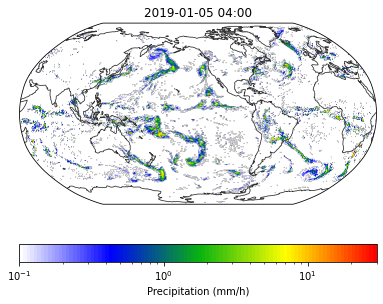

In [6]:
itime = 100
im = egh.healpix_show(ds.precipitation.isel(time=itime),norm=mpl.colors.LogNorm(vmin=10e-2, vmax=30), cmap=cmaps.WhBlGrYeRe)
time_str = ds.time.isel(time=itime).dt.strftime('%Y-%m-%d %H:%M').item()
plt.title(time_str)
plt.colorbar(im, orientation='horizontal', label='Precipitation (mm/h)')

<Figure size 460.8x345.6 with 0 Axes>

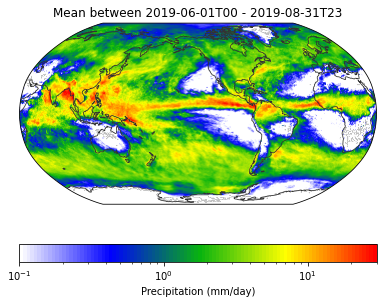

In [7]:
time_str1 = '2019-06-01T00'
time_str2 = '2019-08-31T23'
pcp_avg = ds.precipitation.sel(time=slice(time_str1, time_str2)).mean(dim='time') * 24
im = egh.healpix_show(pcp_avg,norm=mpl.colors.LogNorm(vmin=10e-2, vmax=30), cmap=cmaps.WhBlGrYeRe)
plt.title(f'Mean between {time_str1} - {time_str2}')
plt.colorbar(im, orientation='horizontal', label='Precipitation (mm/day)')

<Figure size 460.8x345.6 with 0 Axes>

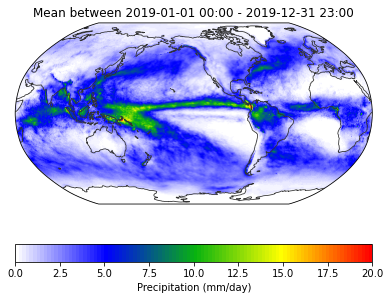

In [8]:
pcp_avg = ds.precipitation.mean(dim='time') * 24
im = egh.healpix_show(pcp_avg,norm=mpl.colors.Normalize(vmin=0, vmax=20), cmap=cmaps.WhBlGrYeRe)
time_str1 = ds.time.min().dt.strftime('%Y-%m-%d %H:%M').item()
time_str2 = ds.time.max().dt.strftime('%Y-%m-%d %H:%M').item()
plt.title(f'Mean between {time_str1} - {time_str2}')
plt.colorbar(im, orientation='horizontal', label='Precipitation (mm/day)')